# Classification with an Academic Success Dataset

## Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [ ]:
print("Dataset shape (rows, columns):", train.shape)

In [ ]:
print("First 5 rows:")
train.head()

In [ ]:
print("\nStatistical summary:")
train.describe()

In [ ]:
print("\nMissing values in each column:")
train.isnull().sum()

In [ ]:
print("\nNumber of duplicate rows:")
print(train.duplicated().sum())

print("\nUnique classes:")
print(train['Target'].unique())

In [ ]:
print("\nDataset information:")
train.info()

In [ ]:
target_counts = train['Target'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot
sb.barplot(
    x=target_counts.index,
    y=target_counts.values,
    hue=target_counts.index,
    palette="viridis",
    dodge=False,
    legend=False,
    ax=axes[0]
)
axes[0].set_xlabel("Target", fontsize=14)
axes[0].set_ylabel("Frequency", fontsize=14)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# Pie chart
axes[1].pie(
    target_counts.values,
    labels=target_counts.index,
    autopct='%1.1f%%'
)

fig.suptitle("Target Distribution", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

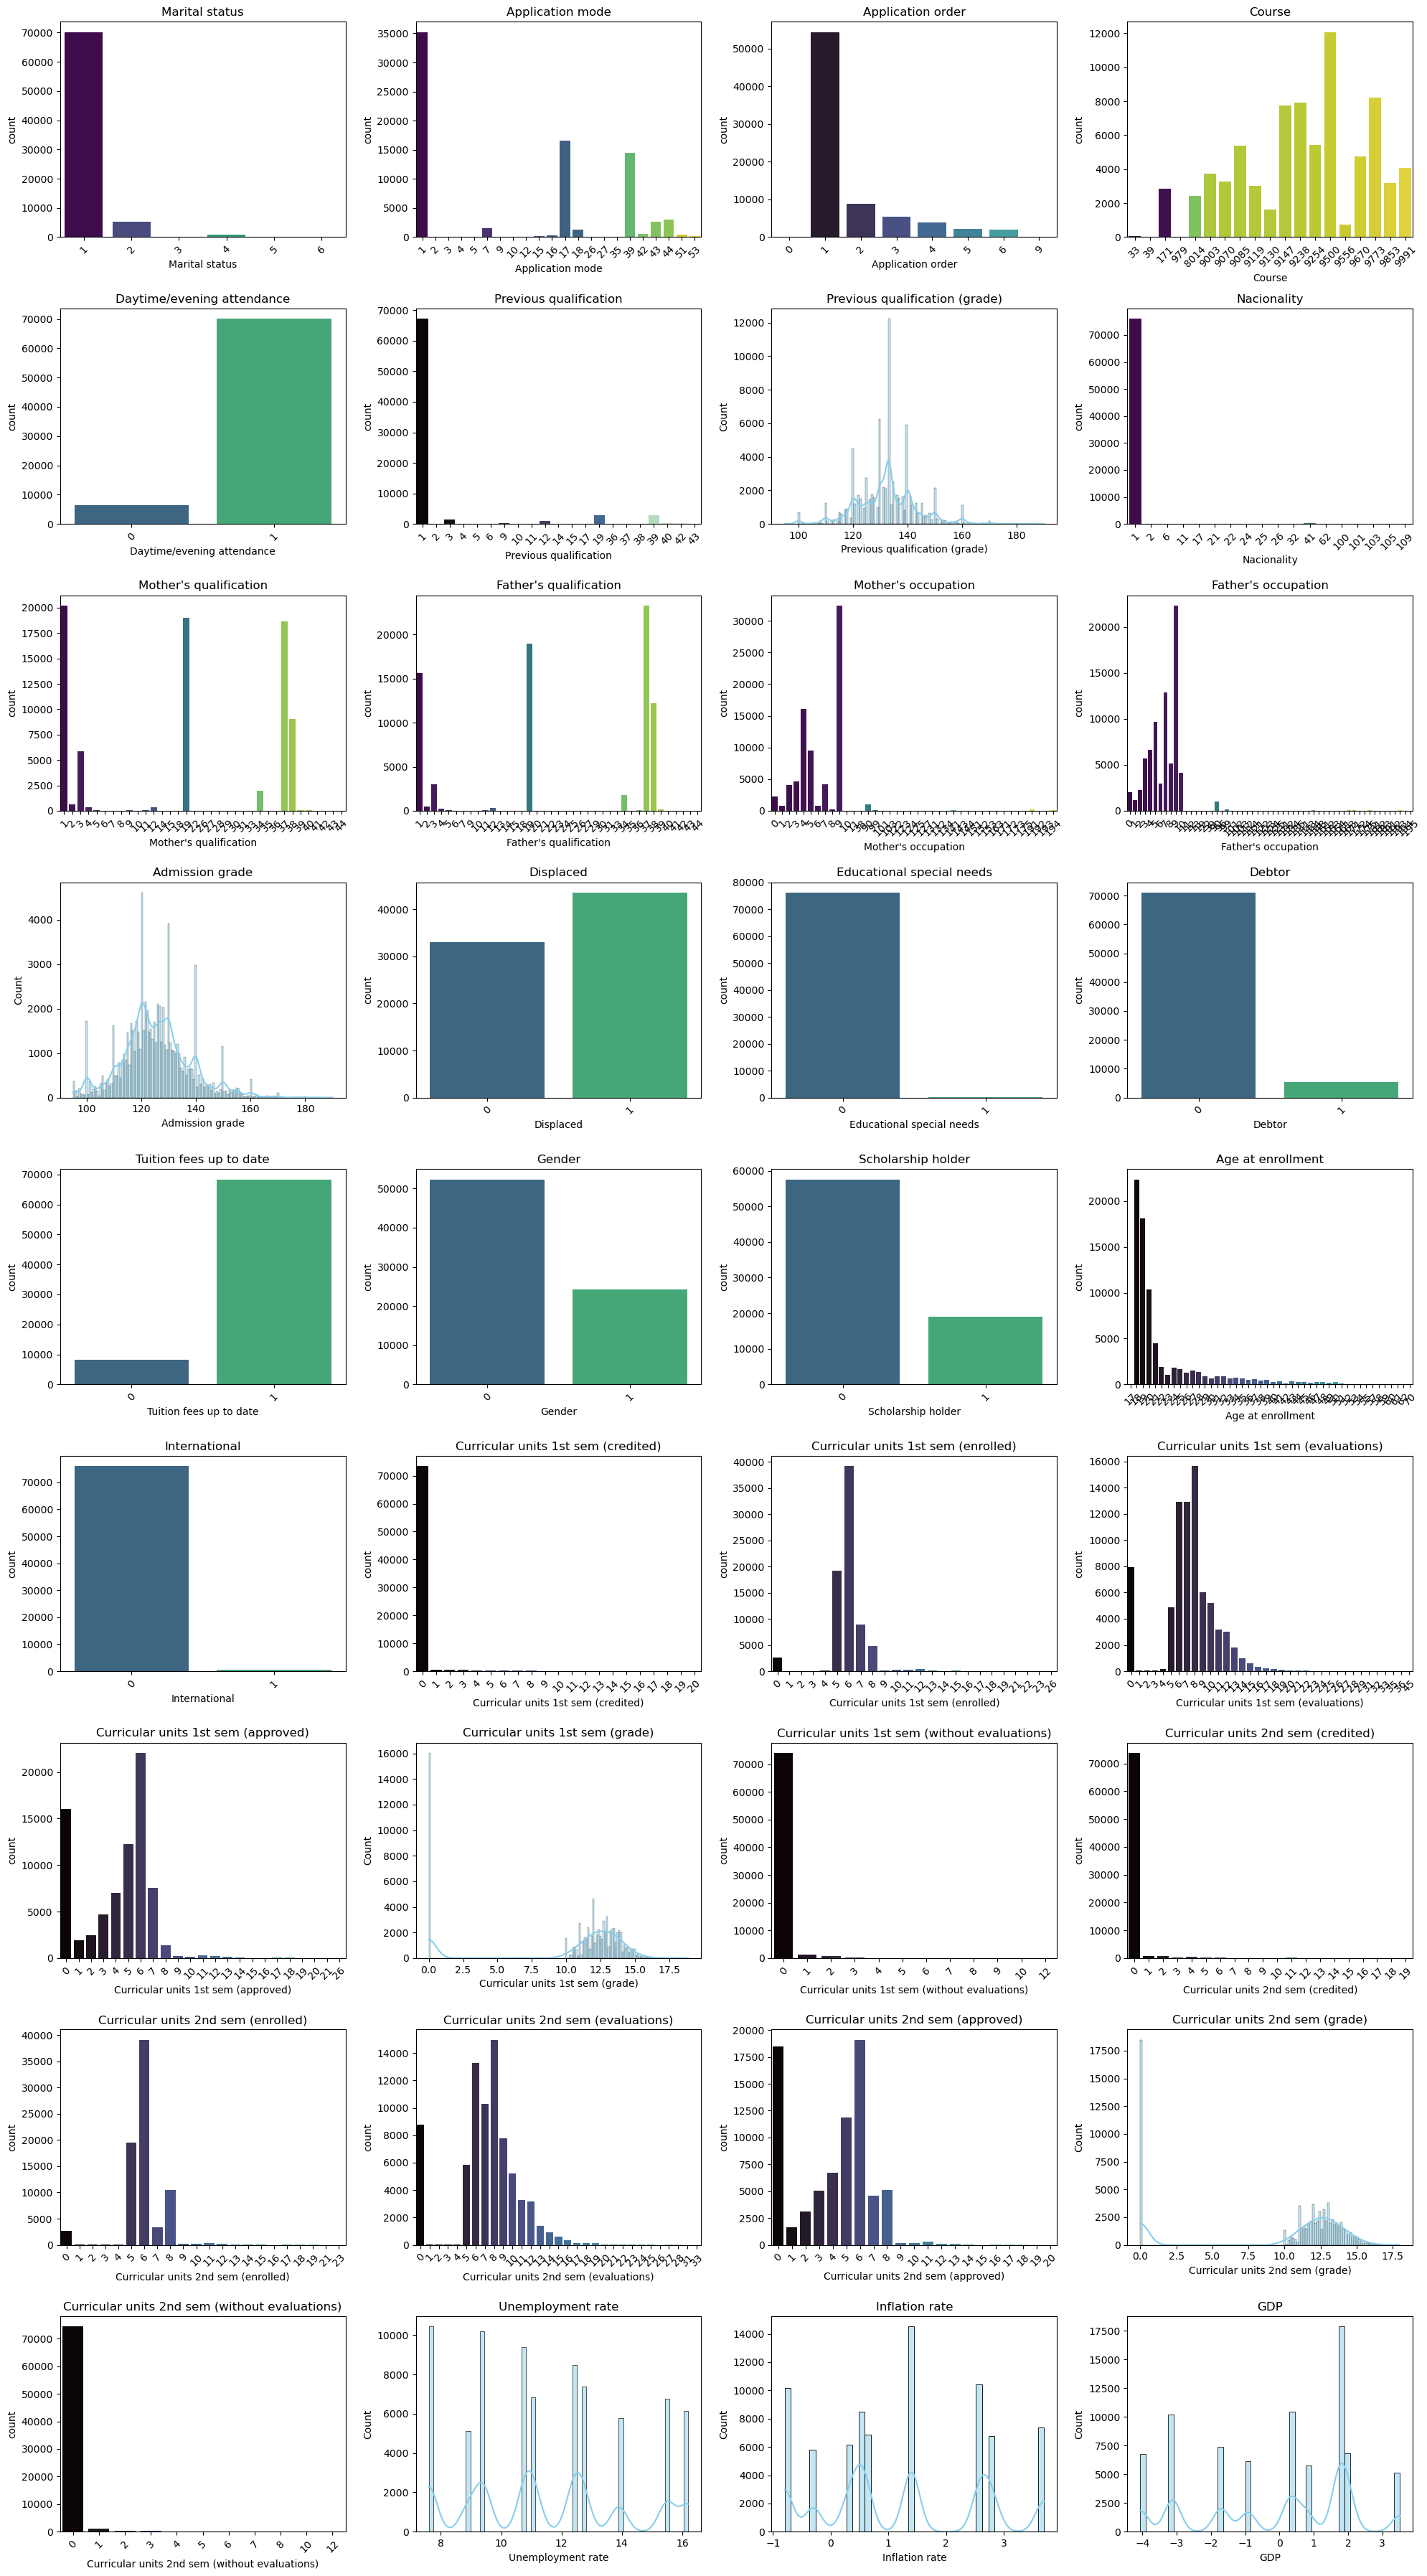

In [3]:
cat_vars = ['Marital status', 'Application mode', 'Course', 'Daytime/evening attendance',
            'Previous qualification	', 'Nacionality', "Mother's qualification",
            "Father's qualification", "Mother's occupation", "Father's occupation",
            'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date',
            'Gender', 'Scholarship holder', 'International']

features_to_plot = [col for col in train.columns if col not in ['id', 'Target']]

n_cols = 4
n_rows = int(np.ceil(len(features_to_plot) / n_cols))
plt.figure(figsize=(n_cols * 5, n_rows * 4))

for idx, col in enumerate(features_to_plot, 1):
    plt.subplot(n_rows, n_cols, idx)
    if col in cat_vars:
        sb.countplot(data=train, x=col, hue=col, palette="viridis", legend=False)
        plt.xticks(rotation=45)
    else:
        if train[col].dtype == 'int64':
            sb.countplot(data=train, x=col, hue=col, palette="mako", legend=False)
            plt.xticks(rotation=45)
        elif train[col].dtype == 'float64':
            sb.histplot(train[col], kde=True, color="skyblue")
    plt.title(col)
    plt.tight_layout()

plt.show()